In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from pyCascade import probePost, physics, utils
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

In [2]:
hm = 6
window_dim = hm/2/4

velocity_scaling = 1
ventilation_scaling = velocity_scaling/(window_dim**2)

norm_vel = probePost.quick_dict_apply(lambda data_df: data_df*velocity_scaling)
norm_vent = probePost.quick_dict_apply(
    lambda data_df: data_df*velocity_scaling)
abs_values = probePost.quick_dict_apply(lambda df: df.abs())
norm_data = lambda data_df : data_df*ventilation_scaling
flip_data = probePost.quick_dict_apply(lambda data_df: -data_df)


In [3]:
run = 15
qois = ["mass_flux", "comp(u,0)"]

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'

probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qois)


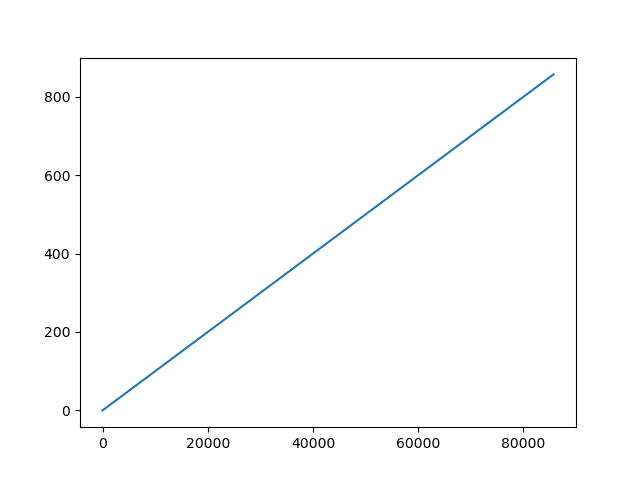

In [4]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)
plt.show()

In [5]:
start = 1
stop = -2
by = 1

processing data took 1 seconds


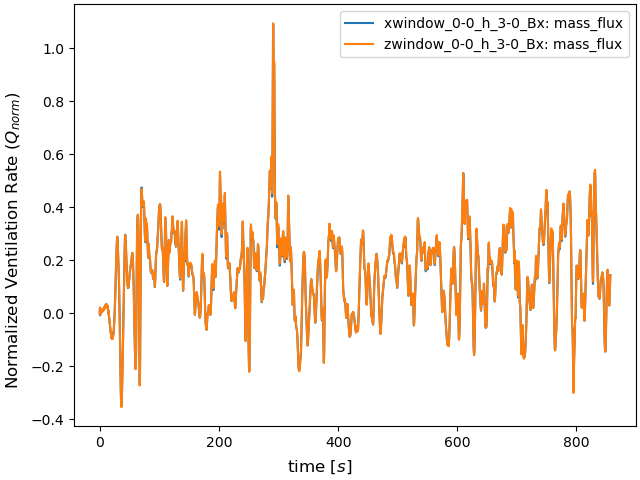

In [6]:
norm_norm = probePost.quick_apply(
    lambda df: probePost.mul_names(df, ['xwindow_2-0', 'xwindow_2-1'], -1)
)

(fig, ax) = probes.time_plots(
    names = ["xwindow_0-0_h_3-0_Bx", "zwindow_0-0_h_3-0_Bx"], #[name for name in  probes.probe_names if "xwindow_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = [qois[0]],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, norm_norm],
    parrallel=True
    )

processing data took 0 seconds


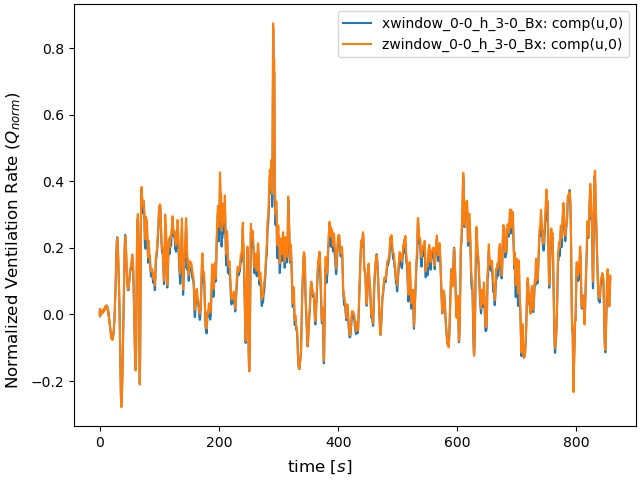

In [7]:
norm_norm = probePost.quick_apply(
    lambda df: probePost.mul_names(df, ['xwindow_2-0', 'xwindow_2-1'], -1)
)

(fig, ax) = probes.time_plots(
    names = ["xwindow_0-0_h_3-0_Bx", "zwindow_0-0_h_3-0_Bx"], #[name for name in  probes.probe_names if "xwindow_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = [qois[1]],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, norm_norm],
    parrallel=True
    )

processing data took 0 seconds


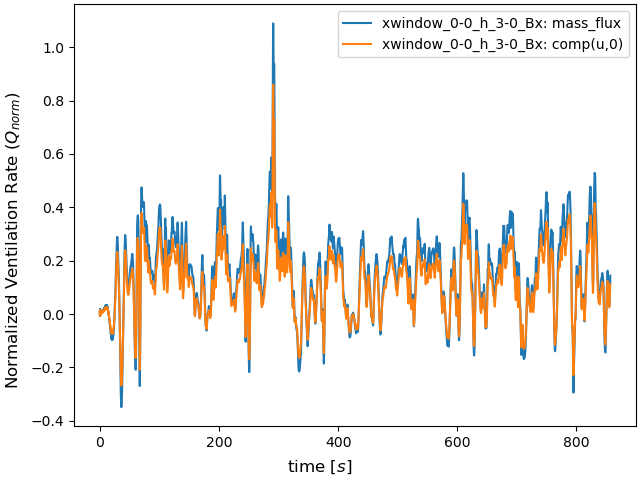

In [8]:
norm_norm = probePost.quick_apply(
    lambda df: probePost.mul_names(df, ['xwindow_2-0', 'xwindow_2-1'], -1)
)

(fig, ax) = probes.time_plots(
    names = ["xwindow_0-0_h_3-0_Bx"], #[name for name in  probes.probe_names if "xwindow_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, norm_norm],
    parrallel=True
    )

(0.0, 2.45)

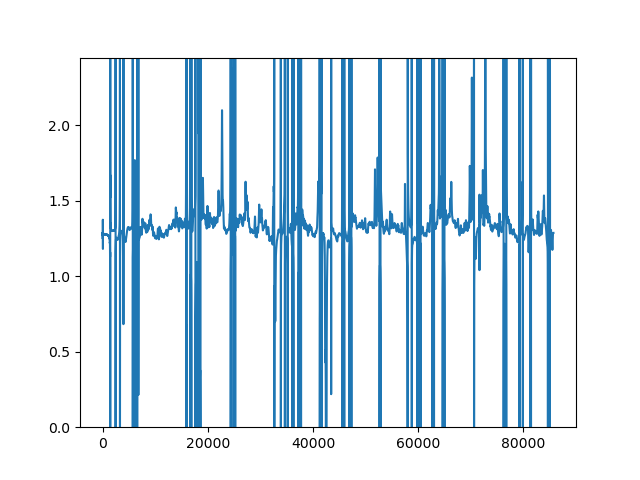

In [9]:
plt.figure()
foo_mass = probes.data[("xwindow_0-0_h_3-0_Bx", qois[0])].compute()
foo_u = probes.data[("xwindow_0-0_h_3-0_Bx", qois[1])].compute()
foo_area = probes.areas["xwindow_0-0_h_3-0_Bx"]
plt.plot(foo_mass.values/foo_u.values)
plt.ylim(0,1.225*2)


0.5625

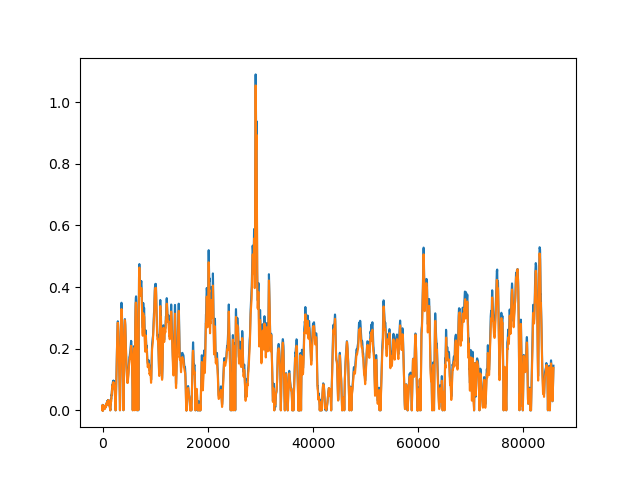

In [10]:
plt.figure()
plt.plot(abs(foo_mass.values))
plt.plot(abs(foo_u.values*1.225))
display(foo_area)
plt.show()

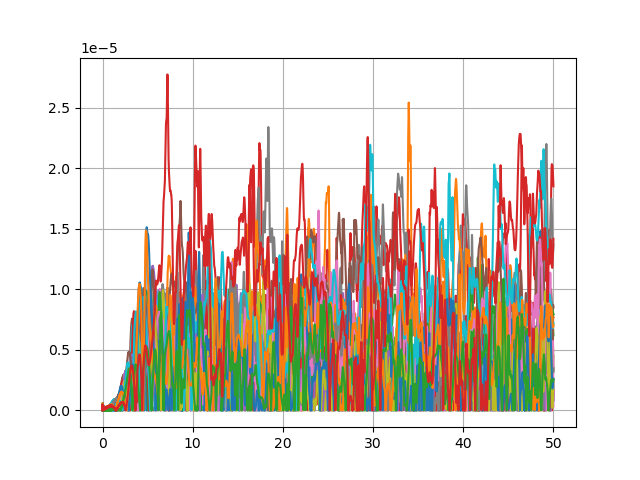

In [11]:
plt.figure()
for name in probes.probe_names:
    if "xwindow_0-0" in name:
        mass_flow = probes.data[(name, qois[0])].compute()
        N = len(mass_flow)
        T = probes.dt
        
        yf = sp.fft.fft(mass_flow)
        xf = sp.fft.fftfreq(N, T)[:N//2]
        
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
        
plt.grid()

plt.show()

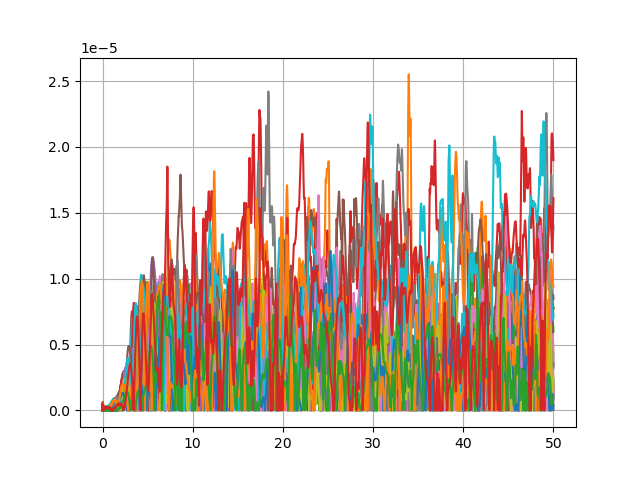

In [17]:
plt.figure()
for name in probes.probe_names:
    if "zwindow_0-0" in name:
        mass_flow = probes.data[(name, qois[0])].compute()
        N = len(mass_flow)
        T = probes.dt
        
        yf = sp.fft.fft(mass_flow)
        xf = sp.fft.fftfreq(N, T)[:N//2]
        
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
        
plt.grid()

plt.show()

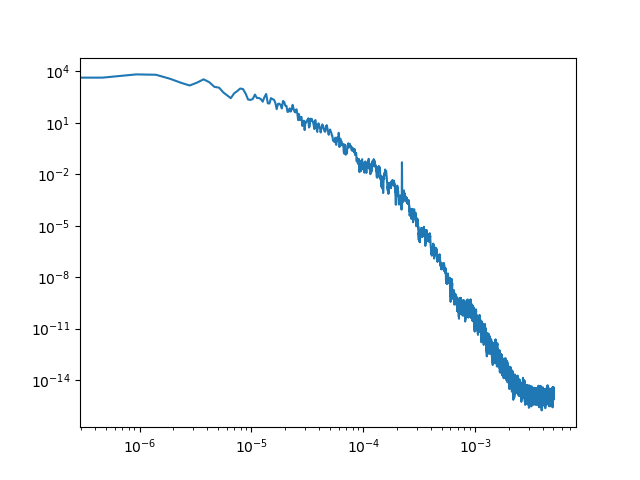

In [22]:
plt.figure()
f, E = sp.signal.welch(foo_mass.values, fs = probes.dt, axis = 0, nperseg = N//4, scaling = 'density', detrend = 'constant') 
plt.loglog(f, E)

## X Flow


processing data took 1 seconds


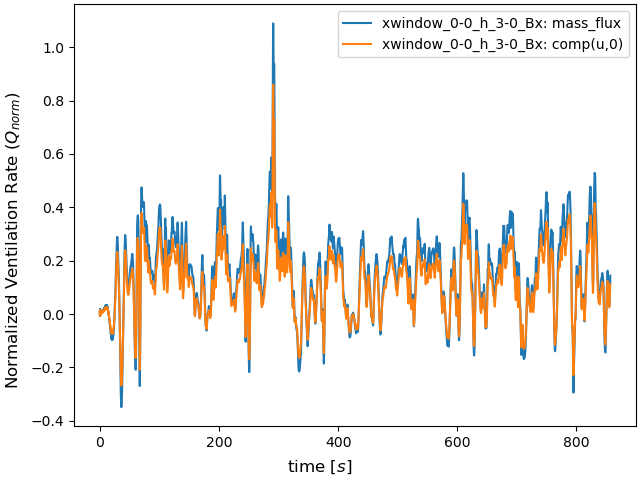

In [16]:
norm_norm = probePost.quick_apply(
    lambda df: probePost.mul_names(df, ['xwindow_2-0', 'xwindow_2-1'], -1)
)

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "xwindow_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, norm_norm],
    parrallel=True
    )

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, norm_norm],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
x_net = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )


display(x_mean)
display(x_rms)
display(x_net)

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows')

x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

## Z Flow


In [ ]:
norm_norm = probePost.quick_apply(
    lambda df: probePost.mul_names(df, ['zwindow_0-1', 'zwindow_1-1', 'zwindow_2-1'], -1)
)

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, probePost.linear_quadrature],
    parrallel=True
    )

## mean statistics
z_mean = ventilation_scaling * probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_average, norm_norm],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
z_net = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.linear_quadrature, abs_values, probePost.time_average],
    parrallel=False
    )

display(z_mean)
display(z_rms)
display(z_net)

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows')

z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

## Y Flow


In [ ]:
(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, probePost.linear_quadrature],
    parrallel=True
    )

## mean statistics
y_mean = ventilation_scaling * probes.statistics(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_average],
    parrallel=False
    )

## rms statistics
y_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.linear_quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
y_net = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight_" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.linear_quadrature, abs_values, probePost.time_average],
    parrallel=False
    )

display(y_mean)
display(y_rms)
display(y_net)

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/ywindows')

y_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ymean.csv')
y_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/yrms.csv')
y_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ynet.csv')